In [1]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import json
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os

Using TensorFlow backend.
C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
df = pd.read_csv('../data/english_labels_with_tweets.csv')
print(df.Type.unique())
types=['self-disclosure', 'report', 'denial', 'accusation', 'cyberbullying', 'other']

df = df.loc[df['Type'].isin(types)]
print(df.Type.unique())
print(df)

['self-disclosure' nan 'report' 'denial' 'accusation' 'cyberbullying']
['self-disclosure' 'report' 'denial' 'accusation' 'cyberbullying']
                Tweet ID    User ID Bullying_Traces?             Type  \
0     105730486382497793  322329899                y  self-disclosure   
6     102533497637437441   70412906                y           report   
7     103441158314790912  221102655                y  self-disclosure   
15    103557373079199744  207378439                y  self-disclosure   
20    101495938232750080  331380807                y  self-disclosure   
...                  ...        ...              ...              ...   
2430  102730819231166465    6872532                y           report   
2434  104568731778285569  135040936                y           denial   
2435  105430902951251969  148111013                y  self-disclosure   
2436  107395299085008896  131482264                y  self-disclosure   
2440  103657243970502656  219840796                y       

In [10]:
# Convert to list
data = df.Text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['mr. walt, stop being a bully.']


In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['mr', 'walt', 'stop', 'being', 'bully']]


In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['mr', 'walt', 'stop', 'being', 'bully']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['mr', 'walt', 'stop', 'bully']]


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


[[('bully', 1), ('mr', 1), ('stop', 1), ('walt', 1)]]

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.073*"bully" + 0.023*"co" + 0.021*"com" + 0.015*"time" + 0.012*"mean" + '
  '0.011*"new" + 0.010*"head" + 0.009*"video" + 0.009*"person" + '
  '0.008*"bedroom"'),
 (1,
  '0.092*"bully" + 0.017*"hate" + 0.015*"do" + 0.014*"need" + 0.012*"well" + '
  '0.011*"try" + 0.010*"shit" + 0.010*"name" + 0.010*"send" + 0.010*"girl"'),
 (2,
  '0.107*"bully" + 0.034*"get" + 0.022*"stop" + 0.020*"m" + 0.016*"see" + '
  '0.015*"do" + 0.014*"bullying" + 0.013*"ass" + 0.010*"feel" + 0.010*"know"'),
 (3,
  '0.067*"bully" + 0.027*"school" + 0.023*"go" + 0.019*"lol" + 0.015*"give" + '
  '0.013*"say" + 0.012*"s" + 0.012*"shit" + 0.012*"co" + 0.012*"bullying"'),
 (4,
  '0.057*"bully" + 0.035*"people" + 0.016*"get" + 0.015*"make" + 0.013*"want" '
  '+ 0.012*"s" + 0.011*"bullying" + 0.009*"stand" + 0.007*"man" + '
  '0.006*"facebook"')]


In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.332931519884429

Coherence Score:  0.4594790364380124


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.169378  0.048768       1        1  28.031623
3      0.065853 -0.094296       2        1  21.875618
1     -0.043291  0.165771       3        1  17.786706
0     -0.149887 -0.000644       4        1  16.753128
4     -0.042053 -0.119598       5        1  15.552925, topic_info=         Term       Freq      Total Category  logprob  loglift
183    people  42.000000  42.000000  Default  30.0000  30.0000
132    school  47.000000  47.000000  Default  29.0000  29.0000
128        go  28.000000  28.000000  Default  28.0000  28.0000
2        stop  34.000000  34.000000  Default  27.0000  27.0000
107       get  76.000000  76.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
4       great   3.921353   6.148439   Topic5  -5.3937   1.4112
107       get  13.832368  76.819899   Topic5  -4.1331   0.1465
32   bullying   9.418107  45.300382   Topic5  -4.5175   0.2902
17        say   4.322556  20.684644   Topic5  -5.2962   0.2954
14     friend   3.367579  16.012412   Topic5  -5.5459   0.3018

[239 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
248       3  0.977907   abuse
1597      4  0.885223  affect
676       1  0.839962    alex
507       5  0.820751    also
188       2  0.906132  always
...     ...       ...     ...
379       5  0.854917   world
202       3  0.924762   wrong
932       3  0.959659     www
670       3  0.869813    year
1699      4  0.883937   yfrog

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

In [22]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8'
mallet_path = "C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('bully', 0.09251700680272108),
   ('people', 0.05986394557823129),
   ('video', 0.02585034013605442),
   ('call', 0.02585034013605442),
   ('cyber', 0.02312925170068027),
   ('time', 0.021768707482993196),
   ('bad', 0.014965986394557823),
   ('ass', 0.014965986394557823),
   ('mom', 0.013605442176870748),
   ('put', 0.012244897959183673)]),
 (1,
  [('bullying', 0.08677685950413223),
   ('lol', 0.05922865013774105),
   ('shit', 0.02203856749311295),
   ('give', 0.02066115702479339),
   ('nice', 0.01652892561983471),
   ('back', 0.01652892561983471),
   ('man', 0.015151515151515152),
   ('attack', 0.015151515151515152),
   ('bring', 0.011019283746556474),
   ('end', 0.009641873278236915)]),
 (2,
  [('bully', 0.13601036269430053),
   ('school', 0.06994818652849741),
   ('kid', 0.025906735751295335),
   ('hate', 0.023316062176165803),
   ('girl', 0.02072538860103627),
   ('fight', 0.015544041450777202),
   ('day', 0.015544041450777202),
   ('student', 0.014248704663212436),
   ('

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=24, step=3)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


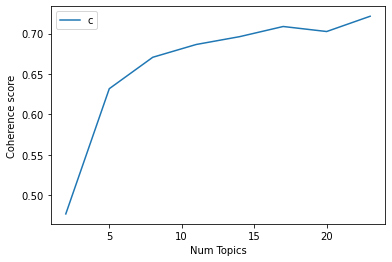

In [35]:
# Show graph
limit=24; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4769
Num Topics = 5  has Coherence Value of 0.6318
Num Topics = 8  has Coherence Value of 0.6707
Num Topics = 11  has Coherence Value of 0.6865
Num Topics = 14  has Coherence Value of 0.6962
Num Topics = 17  has Coherence Value of 0.7088
Num Topics = 20  has Coherence Value of 0.7026
Num Topics = 23  has Coherence Value of 0.7215
